###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# Numerical stability, dispersion and anisotropy of the 2D acoustic finite difference modelling code

Similar to the 1D acoustic FD modelling code, we have to investigate the stability and dispersion of the 2D numerical scheme. Additionally, the numerical dispersion shows in the 2D case an anisotropic behaviour.

Let's begin with the CFL-stability criterion ...

## CFL-stability criterion for the 2D acoustic FD modelling code

As for the 1D code, the maximum size of the timestep $dt$ is limited by the Courant-Friedrichs-Lewy (CFL) criterion:

\begin{equation}
dt \le \frac{dx}{\zeta v_{max}}, \nonumber
\end{equation}

where $dx$ denotes the spatial grid point distance and $v_{max}$ the maximum P-wave velocity. The factor $\zeta$ depends on the used FD-operators, dimension and numerical scheme.

As for the [1D case](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/04_FD_stability_dispersion/1_fd_stability_dispersion.ipynb), we estimate the factor $\zeta$ by the von Neumann analysis, starting with the finite difference approximation of the 2D acoustic wave equation

\begin{equation}
 \frac{p_{j,l}^{n+1} - 2 p_{j,l}^n + p_{j,l}^{n-1}}{\mathrm{d}t^2} \ = \ vp_{j,l}^2\biggl(\frac{p_{j,l+1}^{n} - 2 p_{j,l}^n + p_{j,l-1}^{n}}{\mathrm{d}x^2} + \frac{p_{j+1,l}^{n} - 2 p_{j,l}^n + p_{j-1,l}^{n}}{\mathrm{d}z^2}\biggr),
\end{equation}

and assuming harmonic plane wave solutions for the pressure wavefield of the form:

\begin{equation}
p = exp(i(k_x x + k_z z -\omega t)),\nonumber
\end{equation}

with $i^2=-1$, the wavenumbers $(k_x, k_z)$ in x-/z-direction, respectively, and the circular frequency $\omega$. Using a regular grid with 

$dx = dz = dh,$

discrete spatial coordinates  

$x_j = j dh,$

$z_l = l dh,$

and times 

$t_n = n dt.$

we can calculate discrete plane wave solutions at the discrete locations and times in eq. (1):  

\begin{align}
p_{j,l}^{n+1} &= exp(-i\omega dt)\; p_{j,l}^{n},\\
p_{j,l}^{n-1} &= exp(i\omega dt)\; p_{j,l}^{n},\\
p_{j+1,l}^{n} &= exp(ik_x dh)\; p_{j,l}^{n},\\
p_{j-1,l}^{n} &= exp(-ik_x dh)\; p_{j,l}^{n},\\
p_{j,l+1}^{n} &= exp(ik_z dh)\; p_{j,l}^{n},\\
p_{j,l-1}^{n} &= exp(-ik_z dh)\; p_{j,l}^{n},\\
\end{align}

Inserting eqs. (2) - (7) into eq. (1), division by $p_{j,l}^{n}$ and using the definition: 

\begin{equation}
\cos(x) = \frac{exp(ix) + exp(-ix)}{2},\nonumber
\end{equation}

yields:

\begin{equation}
cos(\omega dt) - 1 = vp_{j,l}^2 \frac{dt^2}{dh^2}\biggl(\{cos(k_x dh) - 1\} + \{cos(k_z dh) - 1\}\biggr).\nonumber
\end{equation}

Some further rearrangements and division of both sides by 2, leads to:

\begin{equation}
\frac{1 - cos(\omega dt)}{2} = vp_{j,l}^2 \frac{dt^2}{dh^2}\biggl(\frac{1 - cos(k_x dh)}{2} + \frac{1 - cos(k_z dh)}{2}\biggr).\nonumber
\end{equation}

With the relation 

\begin{equation}
sin^2\biggl(\frac{x}{2}\biggr) = \frac{1-cos(x)}{2}, \nonumber
\end{equation}

we get 

\begin{equation}
sin^2\biggl(\frac{\omega dt}{2}\biggr) = vp_{j,l}^2 \frac{dt^2}{dh^2}\biggl(sin^2\biggl(\frac{k_x dh}{2}\biggr)+sin^2\biggl(\frac{k_z dh}{2}\biggr)\biggr). \nonumber
\end{equation}

Taking the square root of both sides finally yields 

\begin{equation}
sin\biggl(\frac{\omega dt}{2}\biggr) = vp_{j,l} \frac{dt}{dh}\sqrt{sin^2\biggl(\frac{k_x dh}{2}\biggr)+sin^2\biggl(\frac{k_z dh}{2}\biggr)}.
\end{equation}

This result implies, that if the Courant number

\begin{equation}
\epsilon = vp_{j,l} \frac{dt}{dh} \nonumber
\end{equation}

is larger than $1/\sqrt{2}$, you get only imaginary solutions, while the real part is zero (think for a second why). Consequently, the numerical scheme becomes unstable, when the following CFL-criterion is violated

\begin{equation}
\epsilon = vp_{j,l} \frac{dt}{dh} \le \frac{1}{\sqrt{2}} \nonumber
\end{equation}

Rearrangement to the time step dt, assuming that we have defined a spatial grid point distance dh and replacing $vp_{j,l}$ by the maximum P-wave velocity in the FD model $v_{max}$, leads to 

\begin{equation}
dt  \le \frac{dh}{\sqrt{2}v_{max}}. \nonumber
\end{equation}

Therefore, the factor $\zeta$ in the general CFL-criterion

\begin{equation}
dt  \le \frac{dh}{\zeta vp_j}, \nonumber
\end{equation}

for the FD solution of the 2D acoustic wave equation using the temporal/spatial 3-point operator to approximate the 2nd derivative is $\zeta = \sqrt{2}$. 

Let's check if this result ist correct:

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Definition of modelling parameters
# ----------------------------------
xmax = 5000.0 # maximum spatial extension of the 1D model in x-direction (m)
zmax = xmax   # maximum spatial extension of the 1D model in z-direction (m)
dx   = 10.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)

tmax = 0.8    # maximum recording time of the seismogram (s)
dt   = 0.0010 # time step

vp0  = 3000.  # P-wave speed in medium (m/s)

# acquisition geometry
xr = 2000.0   # x-receiver position (m)
zr = xr       # z-receiver position (m)

xsrc = 2500.0 # x-source position (m)
zsrc = xsrc   # z-source position (m)

f0   = 20. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

In [4]:
# FD_2D_acoustic code with JIT optimization
# -----------------------------------------
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def FD_2D_acoustic_JIT(dt,dx,dz,f0):        
    
    # define model discretization
    # ---------------------------

    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)

    nz = (int)(zmax/dz) # number of grid points in x-direction
    print('nz = ',nz)

    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)

    ir = (int)(xr/dx)      # receiver location in grid in x-direction    
    jr = (int)(zr/dz)      # receiver location in grid in z-direction

    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

    # Analytical solution
    # -------------------
    G    = time * 0.

    # Initialize coordinates
    # ----------------------
    x    = np.arange(nx)
    x    = x * dx       # coordinates in x-direction (m)

    z    = np.arange(nz)
    z    = z * dz       # coordinates in z-direction (m)

    # calculate source-receiver distance
    r = np.sqrt((x[ir] - x[isrc])**2 + (z[jr] - z[jsrc])**2)

    for it in range(nt): # Calculate Green's function (Heaviside function)
        if (time[it] - r / vp0) >= 0:
            G[it] = 1. / (2 * np.pi * vp0**2) * (1. / np.sqrt(time[it]**2 - (r/vp0)**2))
    Gc   = np.convolve(G, src * dt)
    Gc   = Gc[0:nt]

    # Initialize model (assume homogeneous model)
    # -------------------------------------------
    vp    = np.zeros((nx,nz))
    vp2    = np.zeros((nx,nz))

    vp  = vp + vp0       # initialize wave velocity in model
    vp2 = vp**2
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        for i in range(1, nx - 1):
            for j in range(1, nz - 1):
                
                d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
                d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir,jr]        
        
    return time, seis, Gc, p     # return last pressure wave field snapshot

To seperate modelling and visualization of the results, we introduce the following plotting function:

In [5]:
# Compare FD Seismogram with analytical solution
# ---------------------------------------------- 
def plot_seis(time,seis_FD,seis_analy):     
    
    # Define figure size
    rcParams['figure.figsize'] = 12, 5
    
    plt.plot(time, seis_FD, 'b-',lw=3,label="FD solution") # plot FD seismogram
    plt.plot(time, seis_analy,'r--',lw=3,label="Analytical solution") # plot analytical solution
    
    plt.xlim(time[0], time[-1])
    
    plt.title('Seismogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    
    plt.show() 

nx =  500
nz =  500
nt =  339
CPU times: user 1.68 s, sys: 12 ms, total: 1.69 s
Wall time: 1.69 s


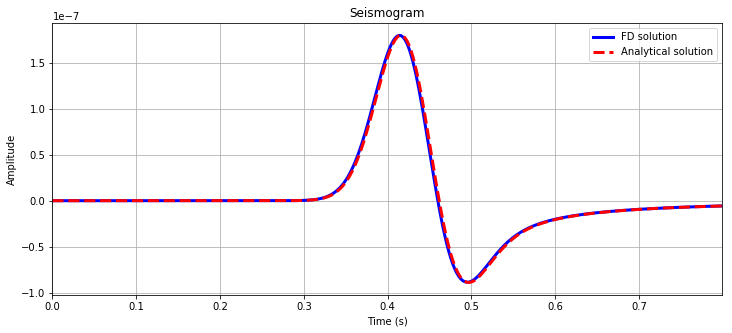

In [6]:
dx   = 10.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 20     # centre frequency of the source wavelet (Hz)

# define 
zeta = np.sqrt(2)

# calculate dt according to the CFL-criterion
dt = dx / (zeta * vp0)

%time time, seis_FD, seis_analy, p = FD_2D_acoustic_JIT(dt,dx,dz,f0)
plot_seis(time,seis_FD,seis_analy)

## Numerical Grid Dispersion

While the FD solution above is stable, it is subject to some numerical dispersion when compared with the analytical solution. The grid point distance $dx = 10\; m$, P-wave velocity $vp = 3000\; m/s$ and a maximum frequency $f_{max} \approx 2*f_0 = 40\; Hz$ leads to ...

In [7]:
fmax = 2 * f0 
N_lam = vp0 / (dx * fmax)
print("N_lam = ",N_lam)

N_lam =  7.5


$N_\lambda = 7.5$ gridpoints per minimum wavelength. Let's increase it to $N_\lambda = 12$, which yields ...

nx =  800
nz =  800
nt =  543
CPU times: user 1.91 s, sys: 12 ms, total: 1.92 s
Wall time: 1.91 s


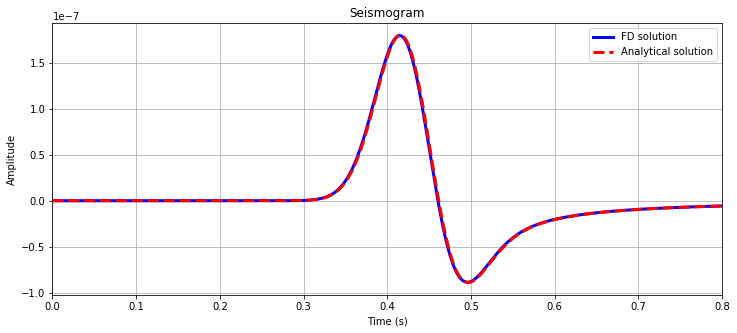

In [8]:
N_lam = 12 
dx   = vp0 / (N_lam * fmax)
dz   = dx     # grid point distance in z-direction (m)
f0   = 20     # centre frequency of the source wavelet (Hz)

# define 
zeta = np.sqrt(2)

# calculate dt according to the CFL-criterion
dt = dx / (zeta * vp0)

%time time, seis_FD, seis_analy, p = FD_2D_acoustic_JIT(dt,dx,dz,f0)
plot_seis(time,seis_FD,seis_analy)

... an improved fit of the 2D analytical by the FD solution.

## Numerical Anisotropy

Compared to the 1D acoustic case, the numerical dispersion behaves a little bit differently in the 2D FD approximation. To illustrate this problem, we model the pressure wavefield for $t_{max} = 0.8\; s$for a fixed grid point distance of $dx = 10\;m$ and a centre frequency of the source wavelet $f0 = 100\; Hz$ which corresonds to $N_\lambda = 1.5$ grid points per minimum wavelength.

In [9]:
# define dx/dz and calculate dt according to the CFL-criterion
dx   = 10.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
# define zeta for the CFL criterion
zeta = np.sqrt(2)
dt = dx / (zeta * vp0)

f0 = 100
time, seis_FD, seis_analy, p = FD_2D_acoustic_JIT(dt,dx,dz,f0)

nx =  500
nz =  500
nt =  339


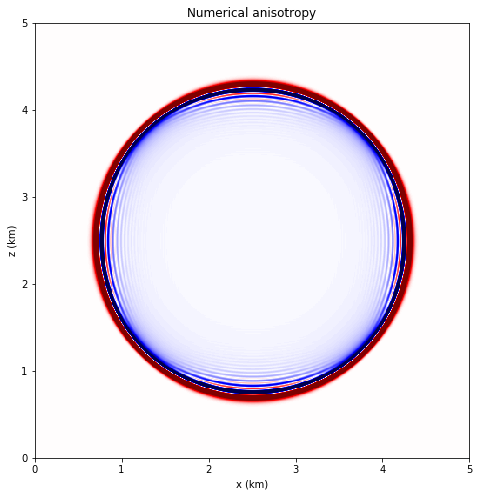

In [10]:
# Plot last pressure wavefield snapshot at Tmax = 0.8 s
# -----------------------------------------------------
rcParams['figure.figsize'] = 8, 8 # define figure size

clip = 1e-7  # image clipping
extent = [0.0, xmax/1000, 0.0, zmax/1000]

# Plot wavefield snapshot at tmax = 0.8 s
plt.imshow(p.T,interpolation='none',cmap='seismic',vmin=-clip,vmax=clip,extent=extent)
plt.title('Numerical anisotropy')
plt.xlabel('x (km)')
plt.ylabel('z (km)')
plt.show()

Clearly, a spatial discretization with $N_\lambda = 1.5$ gridpoints per minimum wavelength leads to modelling results significantly affected by dispersion. However, note that the dispersion is direction dependent. Maximum dispersion coincides with the main Cartesian coordinate axes, while the dispersion reaches a minimum at 45° angles relative to the main axes. This problem is called **Numerical Anisotropy** and can be explained by the angle dependence of the numerical phase velocity.

## What we learned:

* Estimation of the CFL-criterion for the FD approximation of the 2D acoustic wave equation using von Neumann analysis
* Verification of CFL and grid dispersion criterion by 2D numerical FD modelling
* Be aware of the influence of numerical anisotropy on FD modelling results